In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [2]:
#--- Connect to sqlite database
conn = sqlite3.connect('./FPA_FOD_20170508.sqlite')
cursor = conn.cursor()

#--- Store all tables in a dictionary
def sql2pd(tables,conn):
    df = {}
    for table in tables:
        try: 
            query = "SELECT * FROM "+table
            df[table] = pd.read_sql_query(query, conn)
        except:
            pass
    return df

SQLquery = "SELECT name FROM sqlite_master WHERE type='table'"
tables = cursor.execute(SQLquery).fetchall()
tables = [table[0] for table in tables]
df = sql2pd(tables,conn)

---
---
1. What is the distribution of wildfires in California?

In [3]:
California = df['Fires']
California = California[California['STATE'] == 'CA']
print('Size of Original Fires dataset: ', len(df['Fires']), 'Size of California only Fires dataset: ', len(California)) 
print('Simple Check: ', len(df['Fires']) > len(California),'\n\n')
California.head()

Size of Original Fires dataset:  1880465 Size of California only Fires dataset:  189550
Simple Check:  True 




,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [4]:
SpatialDistributionInCalifornia = California[['LATITUDE','LONGITUDE','FIRE_SIZE','FIRE_YEAR']]
SpatialDistributionInCalifornia['FIRE_SIZE_RADIUS'] = np.sqrt(SpatialDistributionInCalifornia['FIRE_SIZE'].values*4047/np.pi)

<ipython-input-4-0bb01157ca5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpatialDistributionInCalifornia['FIRE_SIZE_RADIUS'] = np.sqrt(SpatialDistributionInCalifornia['FIRE_SIZE'].values*4047/np.pi)


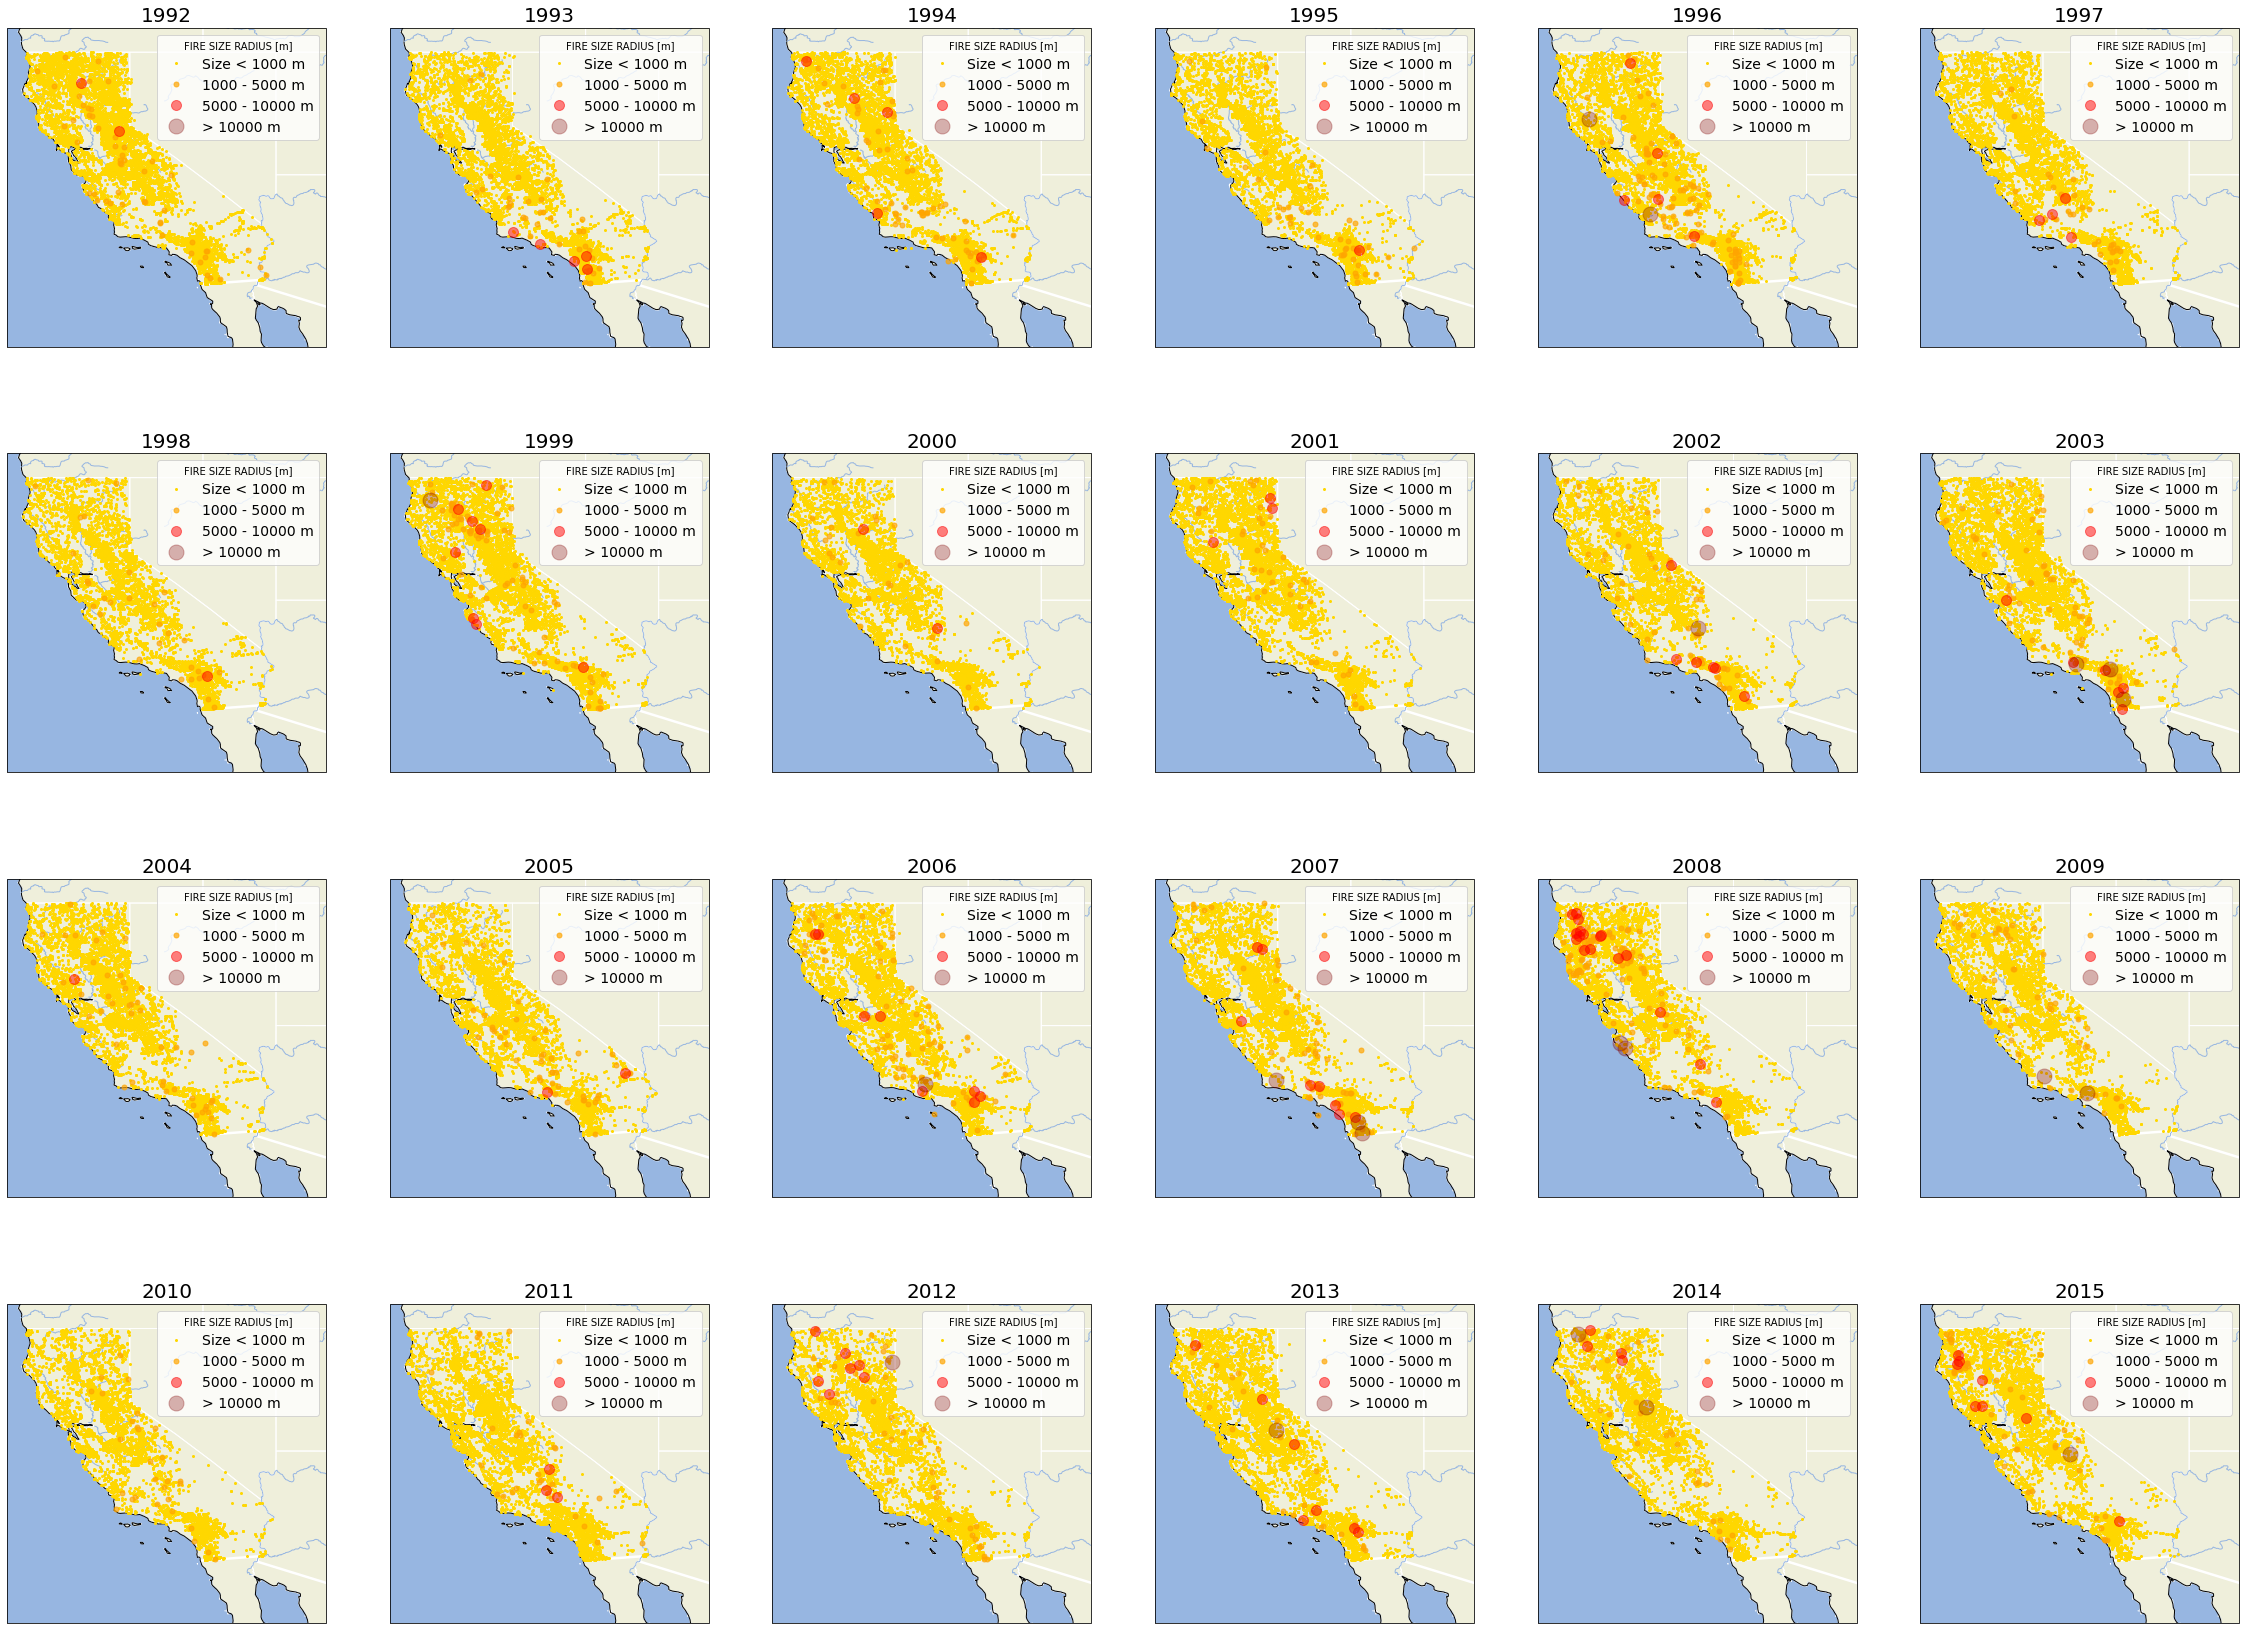

In [5]:
years = [y for y in range(1992,2016)]
fig, axes = plt.subplots(ncols=6,nrows=4,figsize=(40,30),subplot_kw=dict(projection=ccrs.PlateCarree()))
for num, ax in enumerate(axes.flat):
    if num < len(years):
        ax.set_xlim([-125,-112])
        ax.set_ylim([30,43])
        SDCperYear = SpatialDistributionInCalifornia[SpatialDistributionInCalifornia['FIRE_YEAR']==years[num]]

        lat, lon = SDCperYear[SDCperYear['FIRE_SIZE_RADIUS'] < 1000][['LATITUDE','LONGITUDE']].values.T
        ax.plot(lon,lat,'o', color='gold', markersize=2,label='Size < 1000 m')

        lat, lon = SDCperYear[(SDCperYear['FIRE_SIZE_RADIUS'] < 5000) & (SDCperYear['FIRE_SIZE_RADIUS'] > 1000)][['LATITUDE','LONGITUDE']].values.T
        ax.plot(lon,lat,'o', color='orange', markersize=5, alpha = 0.7, label='1000 - 5000 m')

        lat, lon = SDCperYear[(SDCperYear['FIRE_SIZE_RADIUS'] < 10000) & (SDCperYear['FIRE_SIZE_RADIUS'] > 5000)][['LATITUDE','LONGITUDE']].values.T
        ax.plot(lon,lat,'o', color='red', markersize=10, alpha = 0.5, label='5000 - 10000 m')

        lat, lon = SDCperYear[SDCperYear['FIRE_SIZE_RADIUS'] > 10000][['LATITUDE','LONGITUDE']].values.T
        ax.plot(lon,lat,'o', color='maroon', markersize=15, alpha = 0.3, label='> 10000 m')
    
        ax.add_feature(cf.LAND)  
        ax.add_feature(cf.OCEAN)  
        ax.add_feature(cf.STATES, linestyle='-',lw=1.0,edgecolor='white')  
        ax.add_feature(cf.BORDERS, linestyle='-', lw=2.5,edgecolor='white')  
        ax.coastlines(resolution='50m')
        ax.add_feature(cf.RIVERS)
        ax.legend(title = 'FIRE SIZE RADIUS [m]', loc='upper right', fontsize=14)
        ax.set_title(years[num], fontsize=20)
    else: ax.axis('off')

In [6]:
1*4047/np.pi

1288.200109385801